# Unsupervised Learning: Clustering

We want to explore the data with unsupervised techniques in order to get an idea of the distribution of the different variables we will be studying: We will be focused in the Hotels dataset and how it is distributed in terms of different variables.

We will be using the following methods:

- K-means clustering: Scikit learn:
    
- DBSCAN from Scikit learn and also GIS Pro. This algorithm also accounts for spatial distribution

- HDBSCAN from Scikit learn and also GIS Pro.

Interesting websites:

http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html#sphx-glr-auto-examples-cluster-plot-cluster-iris-py

https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

http://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/h-how-cluster-and-outlier-analysis-anselin-local-m.htm


In [1]:
#%reset

In [2]:
#Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
#this function its a .py file developed by aiko
from PlottingFunctions import plot_inertia, plot_silhouette

%load_ext autoreload
%autoreload 2

#Scikit learn & Others
import sklearn.cluster as cluster
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.cluster import KMeans
kmeans = KMeans()
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.special import inv_boxcox
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import hdbscan

#GIS libraries
import json
import geopandas
import arcgis
from arcgis.gis import GIS
from IPython.display import display
gis = GIS()

In [3]:
hotels = pd.read_csv('./Data/hotels_for_modelling.csv')
hotels.drop(labels=['Price_Night_USD','logPrice'], axis=1, inplace=True)
hotels.head()

,Unnamed: 0,Average_Household_Size,Purchasing_Power_Capita,Total_Population,Total_Reviews,Ranking_Users,Hotel_stars,Index,Latitude,Longitude,Housing_Transactions,Median_House_Price,Total_Airbnb_Beds,Median_Airbnb_Price,Total_Restaurants,Median_Restaurant_Ranking,Heathrow,Stansted,Gatwick,City Airport,Tourist_POIs,Business_POIs,Gym,Internet,AC,Parking,Pool,Room_Service,BoxCoxPrice
0,0,1.029619,0.518931,0.065763,7.597396,-1.584253,5.0,0,51.515962,-0.159802,0.823362,13.790194,0.217042,0.417710,5.231109,-0.189167,50,73,60,44,3.277145,3.091042,1.0,1.0,1.0,0.0,0.0,1.0,2.867086
1,1,1.064711,1.502037,-0.546826,6.846943,-0.977880,5.0,1,51.494367,-0.175074,0.236269,14.226958,-0.224972,1.678382,5.017280,0.103751,45,72,45,42,3.332205,3.218876,1.0,1.0,1.0,0.0,0.0,1.0,2.873022
2,2,1.252763,-1.358257,0.215960,8.496990,-1.011197,4.0,2,51.531269,-0.122325,-1.294364,13.476537,0.238430,-0.816699,5.030438,-0.673626,63,59,55,34,3.113515,3.020425,0.0,1.0,1.0,0.0,0.0,0.0,2.754949
3,3,1.064711,-1.135153,-1.050201,8.364042,-1.307720,5.0,3,51.508412,-0.106932,-1.483072,14.042647,-1.027015,-1.105603,4.276666,-0.165794,67,78,50,36,3.191847,2.833213,1.0,1.0,1.0,0.0,0.0,1.0,2.890451
4,4,1.252763,0.401883,-1.866201,8.554296,-1.031187,5.0,4,51.505814,-0.124186,-1.420169,13.955273,-0.706198,2.466303,4.941642,-0.850133,62,78,52,37,3.106080,2.862201,1.0,1.0,1.0,0.0,0.0,1.0,2.815390


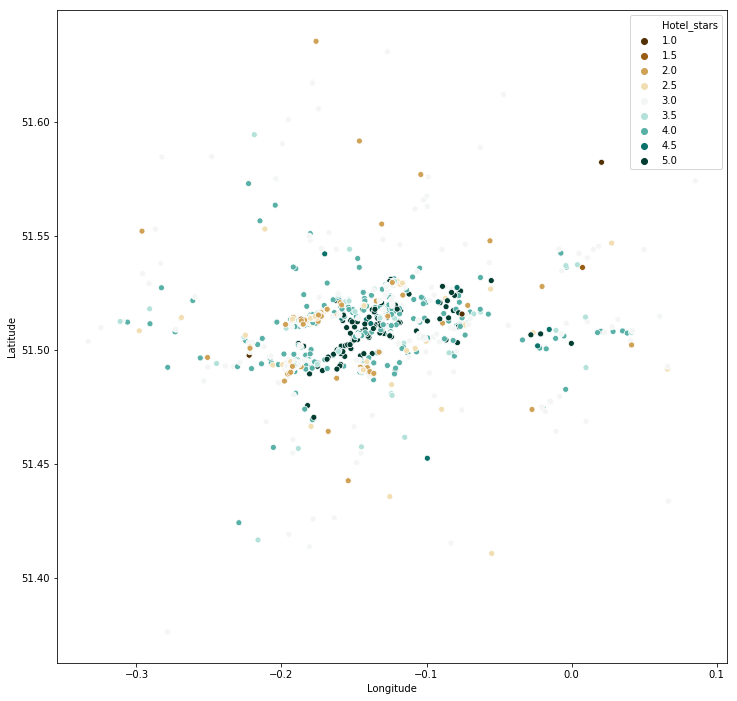

In [4]:
#just to see how the data looks like in terms of coordinates
plt.figure(figsize=(12,12))

sns.scatterplot(x='Longitude', y='Latitude', data=hotels, hue='Hotel_stars', palette='BrBG', legend='full')

## Kmeans clustering

In [5]:
#Selecting the columns we will be using for the clustering, we use the ones with a bigger correlation (either positive or negative)
hotels_clustering = hotels[['BoxCoxPrice','Latitude','Longitude','Median_House_Price','Total_Restaurants', 'Tourist_POIs']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


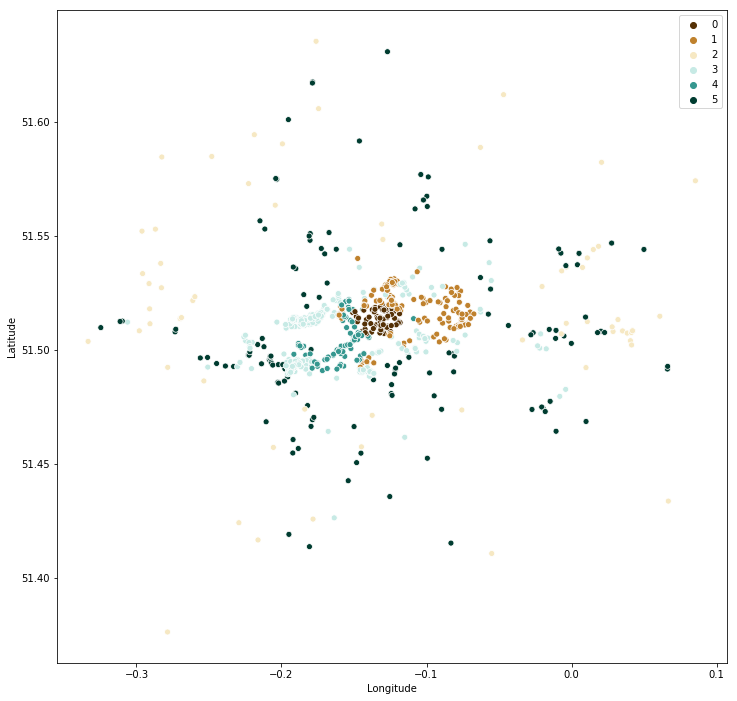

In [6]:
kmeans.set_params(n_clusters=6, max_iter=400)
kmeans.fit(hotels_clustering)

#Saving results to the dataframe for comparation
hotels_clustering['KMEANS'] = kmeans.fit_predict(hotels_clustering)

#Plotting results
plt.figure(figsize=(12,12))
sns.scatterplot(x='Longitude', y='Latitude', data=hotels, hue=kmeans.labels_, palette='BrBG', legend='full')



In [7]:
#the centre of each cluster is giving us information about the elements that conform each cluster
cluster_center = pd.DataFrame(kmeans.cluster_centers_, columns=['BoxCoxPrice','Latitude','Longitude',
                                                                'Median_House_Price','Total_Restaurants',
                                                                'Tourist_POIs'])

#we need to undo the transformations for each column
cluster_center['BoxCoxPrice'] = inv_boxcox(cluster_center['BoxCoxPrice'],-0.27145002)

#Inverse of the standarization
# Remember that the standarization applies the following:
# Mean value subtracted, and then divided by the standard deviation of the whole dataset.
#parameters_scaler = pd.read_csv('./Data/parameters_scaler.csv', index_col='Unnamed: 0')
#cluster_center['Median_Restaurant_Ranking'] = (cluster_center['Median_Restaurant_Ranking'] * parameters_scaler['Median_Restaurant_Ranking']['Sd']) + parameters_scaler['Median_Restaurant_Ranking']['Mean']


#Inverse of the log1p for adressing the skewness
cluster_center['Median_House_Price'] = np.expm1(cluster_center['Median_House_Price'])
cluster_center['Total_Restaurants'] = np.expm1(cluster_center['Total_Restaurants'])
cluster_center['Tourist_POIs'] = np.expm1(cluster_center['Tourist_POIs'])


#we cal also apply the formula
#import numpy as np
#(np.exp(np.log(-0.27294761*2.561028+1)/-0.27294761)) being -0.2 the lambda and 2.56 the value to transfor

cluster_center

,BoxCoxPrice,Latitude,Longitude,Median_House_Price,Total_Restaurants,Tourist_POIs
0,261.609896,51.513113,-0.132620,1.673022e+06,519.202622,21.714371
1,179.408336,51.517804,-0.113067,6.933509e+05,204.940793,22.956160
2,75.243260,51.518876,-0.116078,4.406195e+05,6.735651,41.261667
3,116.140741,51.505825,-0.164419,8.481592e+05,107.220506,29.158522
4,246.865075,51.503824,-0.159619,1.918626e+06,143.325386,25.864023
5,94.864752,51.508748,-0.127179,5.980288e+05,37.413193,35.348707


In [8]:
hotels_clustering.head()

,BoxCoxPrice,Latitude,Longitude,Median_House_Price,Total_Restaurants,Tourist_POIs,KMEANS
0,2.867086,51.515962,-0.159802,13.790194,5.231109,3.277145,1
1,2.873022,51.494367,-0.175074,14.226958,5.017280,3.332205,4
2,2.754949,51.531269,-0.122325,13.476537,5.030438,3.113515,1
3,2.890451,51.508412,-0.106932,14.042647,4.276666,3.191847,3
4,2.815390,51.505814,-0.124186,13.955273,4.941642,3.106080,3


#### Selecting the right amount of clusters

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

**Scree plot**

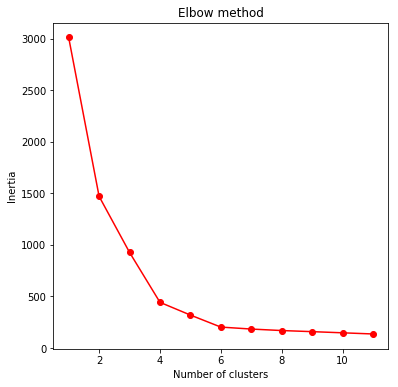

In [9]:
plt.figure(figsize=(6,6))
plot_inertia(kmeans, hotels_clustering, range(1, 12))

## DBSCAN

DBSCAN is a density based algorithm – it assumes clusters for dense regions. It is also the first actual clustering algorithm we’ve looked at: it doesn’t require that every point be assigned to a cluster and hence doesn’t partition the data, but instead extracts the ‘dense’ clusters and leaves sparse background classified as ‘noise’. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or eps in many implementations) to get clusters.

**How to determine the best epsilon?**

The value of eps will have a huge impact on the final number of clusters and distribution of those. For The method proposed here consists of computing the he k-nearest neighbor distances in a matrix of points. The idea is to calculate, the average of the distances of every point to its k nearest neighbors. The value of k will be specified by the user and corresponds to MinPts. Next, these k-distances are plotted in an ascending order. The aim is to determine the “knee”, which corresponds to the optimal eps parameter. A knee corresponds to a threshold where a sharp change occurs along the k-distance curve. 

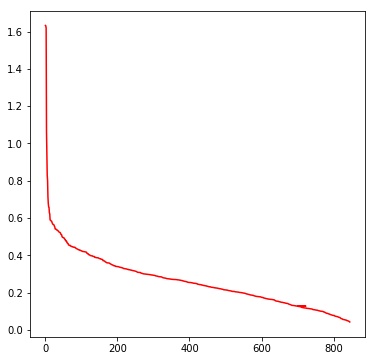

In [10]:
number_of_neighbours = 10
nearest_n = NearestNeighbors(n_neighbors=number_of_neighbours).fit(hotels_clustering)
distances, indices = nearest_n.kneighbors(hotels_clustering)
distanceDec = sorted(distances[:,number_of_neighbours-1], reverse=True)
plt.figure(figsize=(6,6))
plt.plot(indices[:,0], distanceDec, color='r')
#plt.plot(list(range(1,846+1)), distanceDec)

**Interpretation** In the graph below we see as arround 0.6 the value of epsilon is the ideal with a min of 10 points which results in a total of 6 clusters when the algorithm is run.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Number of DBSCAN clusters: 6


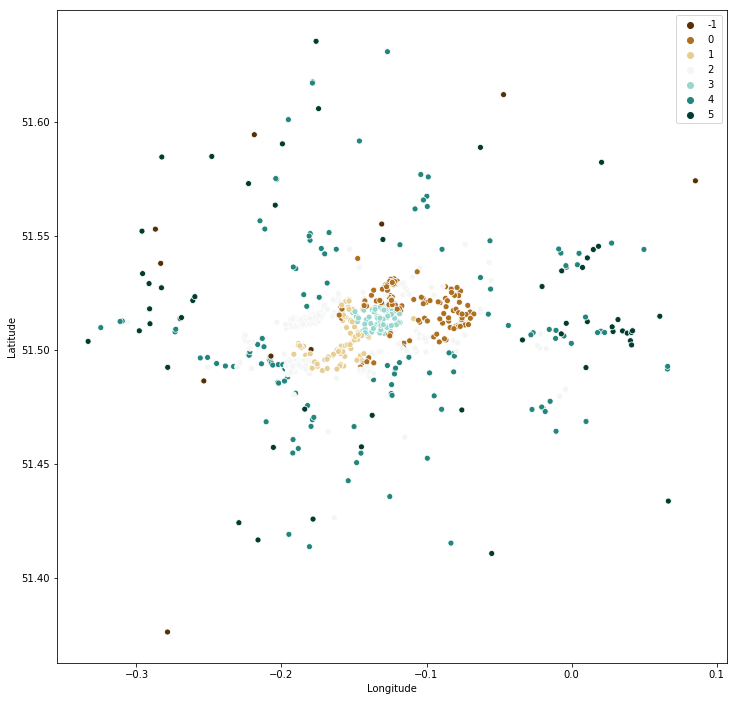

In [11]:
#Selecting the columns we will be using for the clustering
db = DBSCAN(eps=0.5, min_samples=10)
db.fit(hotels_clustering)

#Saving results to the dataframe for comparation
hotels_clustering['DBSCAN'] = db.fit_predict(hotels_clustering)

db_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
print('Number of DBSCAN clusters: ' + str(db_clusters))

#Plotting results
plt.figure(figsize=(12,12))
sns.scatterplot(x='Longitude', y='Latitude', data=hotels, hue=db.labels_, palette='BrBG', legend='full')



In [12]:
hotels_clustering.head()

,BoxCoxPrice,Latitude,Longitude,Median_House_Price,Total_Restaurants,Tourist_POIs,KMEANS,DBSCAN
0,2.867086,51.515962,-0.159802,13.790194,5.231109,3.277145,1,0
1,2.873022,51.494367,-0.175074,14.226958,5.017280,3.332205,4,1
2,2.754949,51.531269,-0.122325,13.476537,5.030438,3.113515,1,0
3,2.890451,51.508412,-0.106932,14.042647,4.276666,3.191847,3,2
4,2.815390,51.505814,-0.124186,13.955273,4.941642,3.106080,3,2


## HDBSCAN

The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points ‘falling out of a cluster’.

The immediate advantage of this is that we can have varying density clusters; the second benefit is that we have eliminated the epsilon parameter as we no longer need it to choose a cut of the dendrogram. Instead we have a new parameter min_cluster_size which is used to determine whether points are ‘falling out of a cluster’ or splitting to form two new clusters.

Number of HDBSCAN clusters: 5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


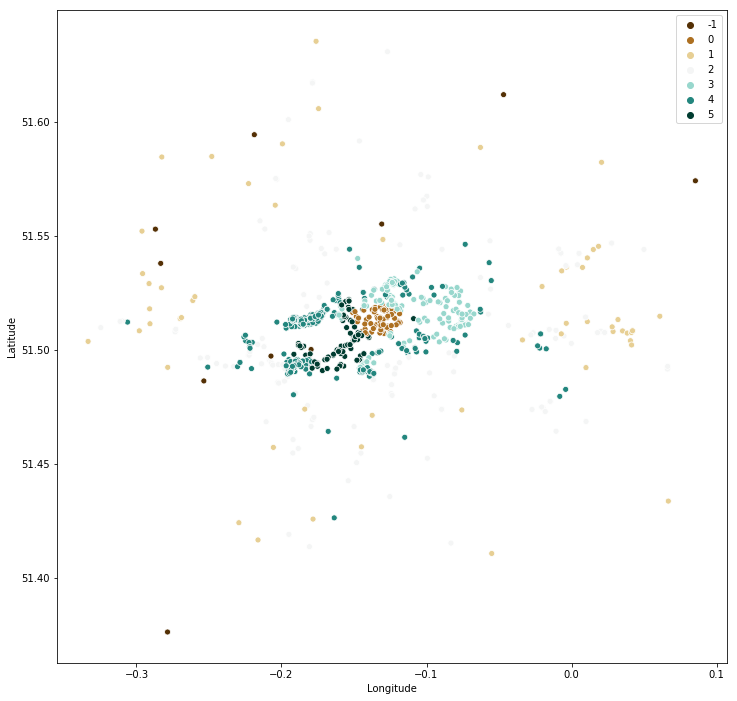

In [13]:
hddb = hdbscan.HDBSCAN(min_cluster_size=10)
hddb.fit(hotels_clustering)

print('Number of HDBSCAN clusters: ' + str(hddb.labels_.max()))

#Saving results to the dataframe for comparation
hotels_clustering['HDBSCAN'] = hddb.fit_predict(hotels_clustering)

#Plotting results
plt.figure(figsize=(12,12))
sns.scatterplot(x='Longitude', y='Latitude', data=hotels, hue=hddb.labels_, palette='BrBG', legend='full')


## Exporting results

In [14]:
hotels_clustering.to_csv('./Data/Clustering/hotels_clustering_sklearn.csv')
hotels_clustering.head()

,BoxCoxPrice,Latitude,Longitude,Median_House_Price,Total_Restaurants,Tourist_POIs,KMEANS,DBSCAN,HDBSCAN
0,2.867086,51.515962,-0.159802,13.790194,5.231109,3.277145,1,0,3
1,2.873022,51.494367,-0.175074,14.226958,5.017280,3.332205,4,1,5
2,2.754949,51.531269,-0.122325,13.476537,5.030438,3.113515,1,0,3
3,2.890451,51.508412,-0.106932,14.042647,4.276666,3.191847,3,2,4
4,2.815390,51.505814,-0.124186,13.955273,4.941642,3.106080,3,2,4


In [15]:
hotels_clustering_for_gis = hotels_clustering[['BoxCoxPrice', 'Latitude',
                                                       'Longitude','Median_House_Price',
                                                       'Total_Restaurants','Tourist_POIs']]
hotels_clustering_for_gis.to_csv('./Data/Clustering/hotels_clustering_for_gis.csv')
hotels_clustering_for_gis.head()

,BoxCoxPrice,Latitude,Longitude,Median_House_Price,Total_Restaurants,Tourist_POIs
0,2.867086,51.515962,-0.159802,13.790194,5.231109,3.277145
1,2.873022,51.494367,-0.175074,14.226958,5.017280,3.332205
2,2.754949,51.531269,-0.122325,13.476537,5.030438,3.113515
3,2.890451,51.508412,-0.106932,14.042647,4.276666,3.191847
4,2.815390,51.505814,-0.124186,13.955273,4.941642,3.106080


**Merging the clusters with the original dataset**

And we will export it for being able to work with the GIS tools.

In [16]:
hotels_original = pd.read_csv('./Data/hotels_final.csv')
hotels_clustering_filtered = hotels_clustering[['KMEANS', 'DBSCAN', 'HDBSCAN' ]]
hotels_clustering_filtered['Index'] = hotels.Index
hotels_clustering_merge = pd.merge(hotels_original, hotels_clustering_filtered , left_on='Index', right_on='Index')
hotels_clustering_merge.to_csv('./Data/Clustering/hotels_clustering_merge.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
hotels_clustering_merge.head()

,Average_Household_Size,Single_Households,Population_Below_14,Population_15_29,Population_30_44,Population_45_59,Purchasing_Power_Capita,Price_Night_USD,Stars_Rating,Total_Households,Total_Population,Total_Reviews,Ranking_Users,Hotel_stars,Index,Latitude,Longitude,Housing_Transactions,Median_House_Price,Airbnb_Listings,Total_Airbnb_Beds,Median_Airbnb_Price,Total_Restaurants,Total_Sum_Of_Reviews,Median_Restaurant_Ranking,Heathrow,Stansted,Gatwick,City Airport,Tourist_POIs,Business_POIs,Gym,Internet,AC,Parking,Pool,Room_Service,KMEANS,DBSCAN,HDBSCAN
0,1.8,2844,1313,2291,3237,1679,45036.36,257.0,5.0,5598,10274,1992,9.0,5.0,0,51.515962,-0.159802,135,975000,104,459,122,186,29844,6829.553763,50,73,60,44,25.500000,21.0,1.0,1.0,1.0,NaN,NaN,1.0,1,0,3
1,1.9,1798,1205,1360,1957,1495,56240.80,264.0,4.5,3874,7419,940,191.0,5.0,1,51.494367,-0.175074,107,1509000,81,335,170,150,32682,7193.633333,45,72,45,42,27.000000,24.0,1.0,1.0,1.0,NaN,NaN,1.0,4,1,5
2,2.5,1772,1629,4421,2335,1489,23642.09,160.0,4.5,4344,10974,4899,181.0,4.0,2,51.531269,-0.122325,34,712500,141,465,75,152,36141,6227.401316,63,59,55,34,21.500000,19.5,NaN,1.0,1.0,NaN,NaN,NaN,1,0,3
3,1.9,1311,351,2164,1082,824,26184.80,286.0,4.5,2618,5073,4289,92.0,5.0,3,51.508412,-0.106932,25,1255000,38,110,64,71,20505,6858.605634,67,78,50,36,23.333333,16.0,1.0,1.0,1.0,NaN,NaN,1.0,3,2,4
4,2.5,255,121,438,301,215,43702.37,205.0,4.5,511,1270,5188,175.0,5.0,4,51.505814,-0.124186,28,1150000,48,200,200,139,50126,6008.014388,62,78,52,37,21.333333,16.5,1.0,1.0,1.0,NaN,NaN,1.0,3,2,4


# Representing Results

**Represent in a map the different types of clusters**

Also we have created an interactive map for further details, link can be found below.

<img src="Images/dbscan_clustering.png" style="width: 80%;">

<img src="Images/hdbscan_clustering.png" style="width: 80%;">

<img src="Images/kmeans_clustering.png" style="width: 80%;">

**Interactive map**

https://jll-maps.carto.com/u/southern/builder/5236be6a-28cc-41e6-92ec-c5144e6aa5ba/embed?

In [7]:
#Displaying the interactive map
from IPython.display import HTML
HTML('<iframe src=https://jll-maps.carto.com/u/southern/builder/5236be6a-28cc-41e6-92ec-c5144e6aa5ba/embed? width=100% height=400></iframe>')

### Summary tables

**DBSCAN**

In [89]:
dbscan_results = hotels_clustering_merge[['Average_Household_Size','Tourist_POIs',
                          'Purchasing_Power_Capita','Total_Restaurants','Median_Airbnb_Price',
                          'Price_Night_USD','Median_House_Price',
                          'DBSCAN']].groupby(['DBSCAN']).mean()

dbscan_results = dbscan_results.reset_index()

#formatting the results
dbscan_results['Average_Household_Size'] = dbscan_results['Average_Household_Size'].map('{:,.1f}'.format)
dbscan_results['Tourist_POIs'] = dbscan_results['Tourist_POIs'].map('{:,.1f}'.format)
dbscan_results['Purchasing_Power_Capita'] = dbscan_results['Purchasing_Power_Capita'].map('£{:,.0f}'.format)
dbscan_results['Total_Restaurants'] = dbscan_results['Total_Restaurants'].map('{:,.0f}'.format)
dbscan_results['Median_Airbnb_Price'] = dbscan_results['Median_Airbnb_Price'].map('${:,.0f}'.format)
dbscan_results['Price_Night_USD'] = dbscan_results['Price_Night_USD'].map('${:,.0f}'.format)
dbscan_results['Median_House_Price'] = dbscan_results['Median_House_Price'].map('£{:,.0f}'.format)


dbscan_results = dbscan_results.sort_values(by='Price_Night_USD', ascending=False)


dbscan_results.rename(columns={'Average_Household_Size': "Average Household size",
                               'Tourist_POIs': 'Average travel time to main Tourist POIs',
                               'Purchasing_Power_Capita': 'Average Purchasing Power per Capita',
                               'Total_Restaurants': 'Average number of sorrounding restaurants',
                               'Median_Airbnb_Price':'Median Airbnb Price ($)',
                               'Price_Night_USD': 'Price per room per night ($)',
                               'Median_House_Price': 'Median House Price (£)',
                               'DBSCAN': 'DBSCAN Clusters'}, inplace=True)

#just to show data in specific order
dbscan_results[['DBSCAN Clusters','Price per room per night ($)',
                'Median House Price (£)','Average travel time to main Tourist POIs',
                'Average Purchasing Power per Capita','Average number of sorrounding restaurants',
               'Median Airbnb Price ($)',"Average Household size"]]

#Kmeans_results
#'Median_House_Price','Total_Restaurants', 'Tourist_POIs

,DBSCAN Clusters,Price per room per night ($),Median House Price (£),Average travel time to main Tourist POIs,Average Purchasing Power per Capita,Average number of sorrounding restaurants,Median Airbnb Price ($),Average Household size
0,-1,$86,"£731,700",50.9,"£26,746",9,$57,2.5
6,5,$83,"£461,704",41.1,"£23,581",9,$54,2.4
4,3,$292,"£1,732,278",21.8,"£43,947",562,$153,1.8
2,1,$286,"£2,017,518",26.3,"£50,580",155,$163,1.9
1,0,$200,"£722,277",23.2,"£35,104",213,$113,2.1
3,2,$131,"£866,737",29.5,"£43,855",110,$104,1.9
5,4,$105,"£628,660",36.2,"£29,842",40,$71,2.2
